In [33]:
from pathlib import Path
import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
sns.set_theme(context='paper',font_scale=1.2,style='whitegrid')
figsize = (5,5)

In [34]:
topn_dockq_df = pd.read_csv('../data/topn_dockq.csv')

# Read RMSD notebook, drop some data

In [35]:
rmsds_df = pd.read_csv('../data/para_epi_interface_rmsds.csv')
pdbs_to_remove = {'7l7e_C0-D0'}
rmsds_df = rmsds_df.loc[[pdb not in pdbs_to_remove for pdb in rmsds_df['pdb']]]
rmsds_df.loc[rmsds_df['model'] == 'AF2', 'model'] = 'AlphaFold2'


In [36]:
print(sorted(rmsds_df['pdb'].unique()))

['7b0b_H0-L0', '7bbg_H0-L0', '7bbj_H0-L0', '7bnv_H0-L0', '7coe_H0-L0', '7daa_H0-L0', '7dk2_A0-B0', '7e3o_H0-L0', '7e5o_H0-L0', '7e72_A0-B0', '7f7e_C0-L0', '7k7h_H0-L0', '7k9j_H0-L0', '7kez_H0-L0', '7kf0_H0-L0', '7kf1_H0-L0', '7kn3_H0-L0', '7kn4_H0-L0', '7kql_H0-L0', '7kyo_H0-L0', '7l0l_H0-L0', '7l7d_H0-L0', '7l7r_B0-A0', '7l7r_D0-C0', '7lf7_A0-B0', '7lfa_B0-D0', '7lfb_H0-L0', '7lr3_H0-L0', '7lr4_H0-L0', '7mdj_A0-B0', '7mrz_X0-Y0', '7msq_D0-E0', '7mzf_H0-L0', '7mzg_H0-L0', '7mzh_H0-L0', '7mzi_H0-L0', '7mzj_H0-L0', '7mzk_N0-M0', '7mzm_H0-L0', '7n3i_H0-L0', '7n4i_H0-L0', '7n4j_H0-L0', '7np1_H0-L0', '7nx3_B0-C0', '7phu_B0-C0', '7phw_B0-C0', '7pi7_B0-C0', '7pr0_H0-L0', '7ps0_H0-L0', '7ps1_A0-B0', '7ps2_A0-B0', '7ps2_H0-L0', '7ps4_H0-L0', '7ps6_C0-D0', '7ps6_H0-L0', '7q0g_A0-B0', '7q0g_H0-L0', '7q0i_H0-L0', '7qnw_A0-B0', '7qny_A0-B0', '7qu1_A0-B0', '7qu2_A0-B0', '7r89_C0-D0', '7r8l_H0-L0', '7rah_B0-A0', '7rah_D0-C0', '7rfb_A0-B0', '7rk1_C0-C1', '7rk2_C0-C1', '7rks_H0-L0', '7s0b_A0-B0', '7s11

# Code for getting top dockq, protocols and stages to run

In [37]:
antigen = 'alphafold2'
model_names = ['ABodyBuilder2','AlphaFold2','ABlooper','IgFold']
protocols = ['CDR-VagueEpi-AA', 'Para-Epi']
stages_to_eval = ['Rigid-body', 'Refinement', 'Clustering']

root_plot_folder = Path('../figures/paratope_epitope_rmsd_dockq/')
root_plot_folder.mkdir(exist_ok=True)


# Plot interface rmsd vs dockq scores


In [38]:
plot_folder = root_plot_folder / "interface_rmsd_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, model_name in enumerate(model_names):
            model_df = rmsds_df.query('model==@model_name').copy()
            top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 1')
            top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 10')

            model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

            model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})

            dockq1_pearson , _ = pearsonr(model_df['rmsd_interface'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['rmsd_interface'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['rmsd_interface'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['rmsd_interface'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['rmsd_interface'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['rmsd_interface'], model_df['dockq_10'])



            sns.scatterplot(x="rmsd_interface", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="rmsd_interface", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'min i-RMSD $\left(\AA\right)$')
        ax_dockq1.set_ylabel(f'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_interface_rmsd_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'min i-RMSD $\left(\AA\right)$')
        ax_dockq10.set_ylabel(f'{stage} DockQ-T10')

        #ax_dockq10.set_xlim([0,5])
        ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_interface_rmsd_all_models_{protocol}_{stage}.png',dpi=200)


# Paratope rmsd

In [39]:
plot_folder = root_plot_folder / "paratope_rmsd_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, model_name in enumerate(model_names):
            model_df = rmsds_df.query('model==@model_name').copy()
            top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 1')
            top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 10')

            model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

            model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})

            dockq1_pearson , _ = pearsonr(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['rmsd_paratope'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['rmsd_paratope'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['rmsd_paratope'], model_df['dockq_10'])



            sns.scatterplot(x="rmsd_paratope", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="rmsd_paratope", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'Paratope RMSD $\left(\AA\right)$')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')
        #ax_dockq1.set_xlim([0,5])
        ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_rmsd_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(fr'Paratope RMSD $\left(\AA\right)$')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_rmsd_all_models_{protocol}_{stage}.png',dpi=200)


# Epitope rmsds

In [40]:
plot_folder = root_plot_folder / "epitope_rmsd_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, model_name in enumerate(model_names):
            model_df = rmsds_df.query('model==@model_name').copy()
            top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 1')
            top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 10')

            model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

            model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})


            dockq1_pearson , _ = pearsonr(model_df['rmsd_epitope'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['rmsd_epitope'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['rmsd_epitope'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['rmsd_epitope'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['rmsd_epitope'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['rmsd_epitope'], model_df['dockq_10'])



            sns.scatterplot(x="rmsd_epitope", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="rmsd_epitope", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'Epitope RMSD $\left(\AA\right)$')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_epitope_rmsd_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'Epitope RMSD $\left(\AA\right)$')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_epitope_rmsd_all_models_{protocol}_{stage}.png',dpi=200)


# Plot af2 dockq vs af2 paratope plddt

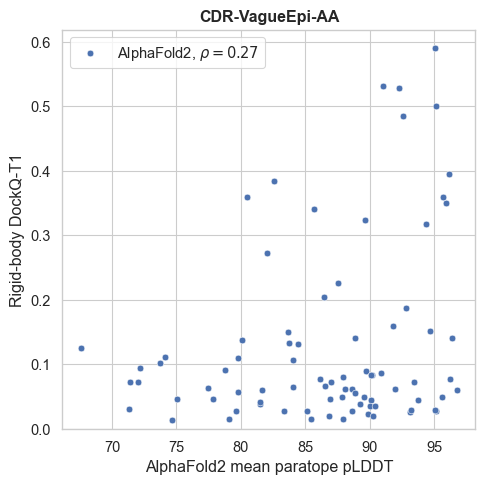

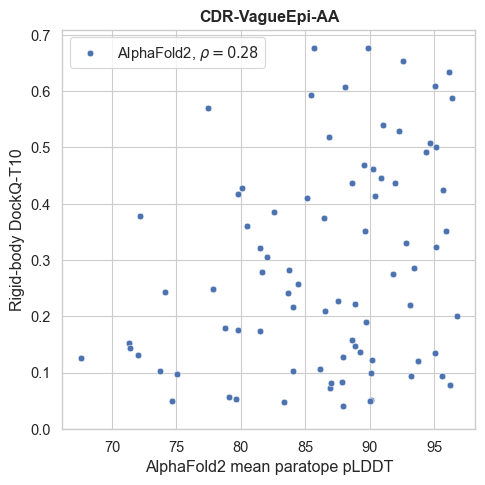

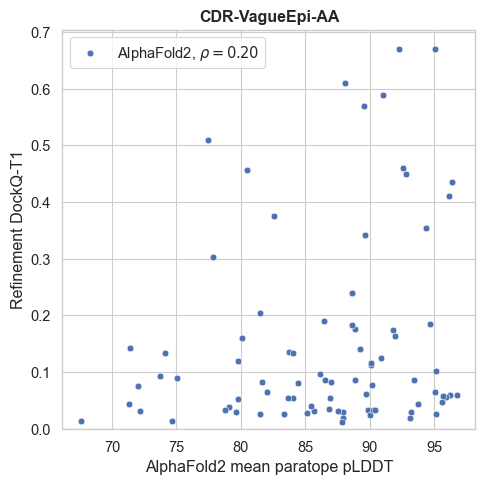

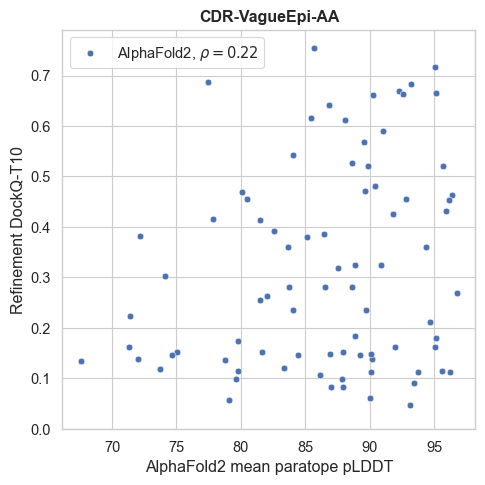

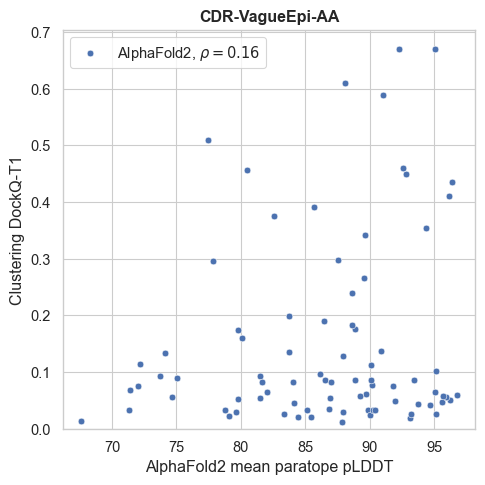

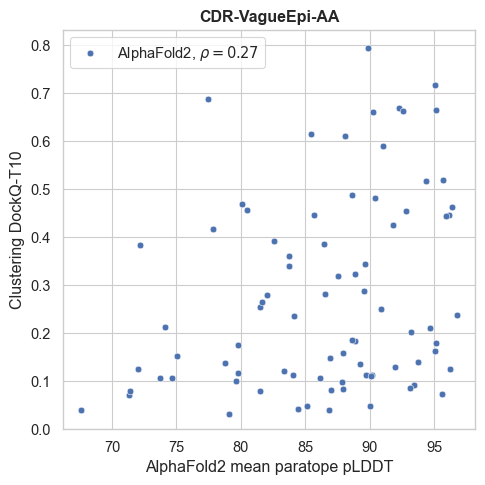

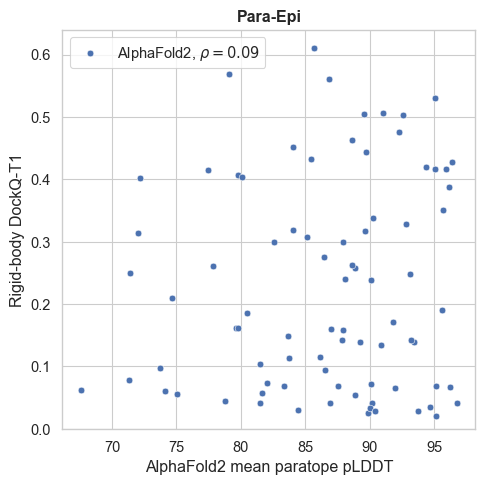

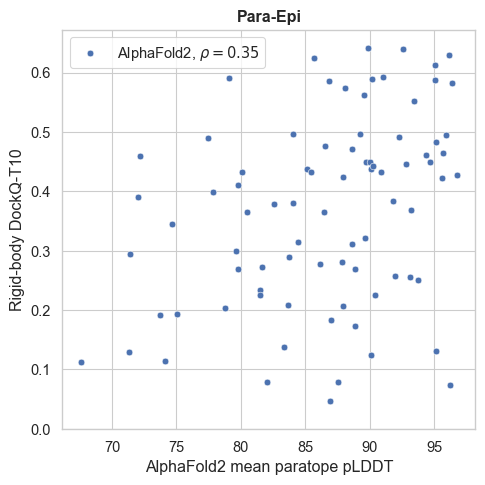

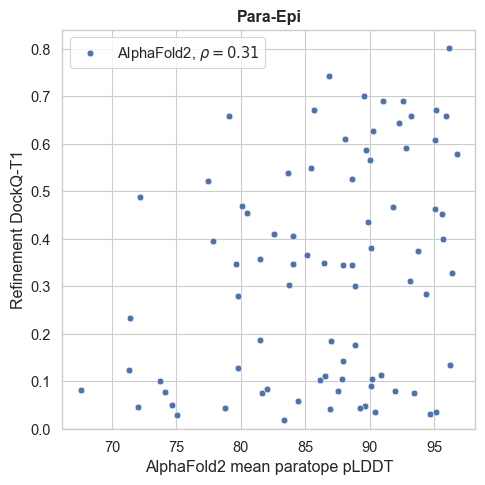

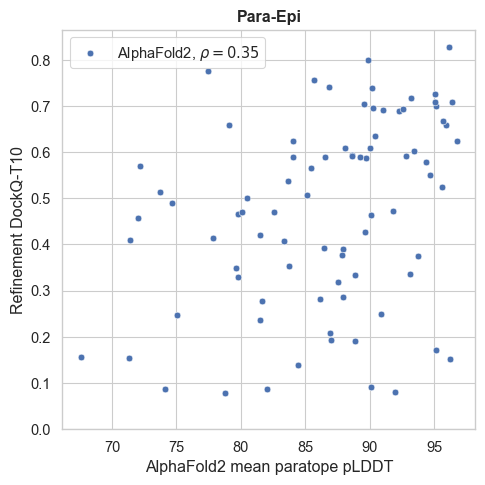

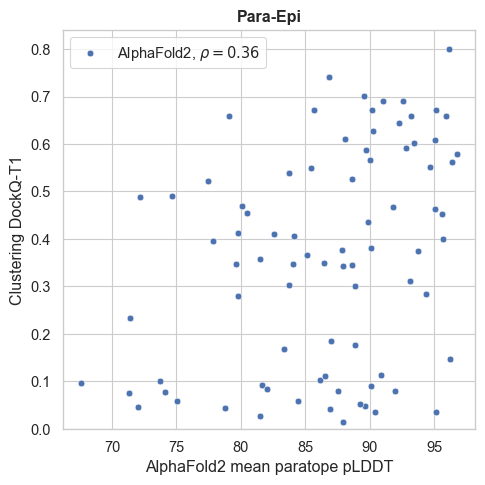

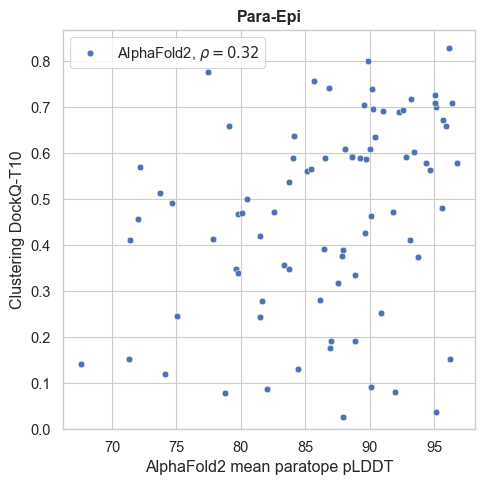

In [41]:
paratope_plddt_df = pd.read_csv('../data/AF2_antibody_rmsd_plddt_multi_regions.csv')
paratope_plddt_dict = {row.pdb : row.plddt_ave_para_epi for row in paratope_plddt_df.itertuples()}
model_name = 'AlphaFold2'

plot_folder = root_plot_folder / "paratope_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 1')
        top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 10')

        model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

        model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})

        model_df['para_ave_plddt'] = [paratope_plddt_dict[pdbid] for pdbid in model_df['pdb']]

        dockq1_pearson , _ = pearsonr(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['para_ave_plddt'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['para_ave_plddt'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['para_ave_plddt'], model_df['dockq_10'])



        sns.scatterplot(x="para_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="para_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean paratope pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_plddt_af2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean paratope pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_plddt_af2_{protocol}_{stage}.png',dpi=200)


# Same but with vague definition of paratope


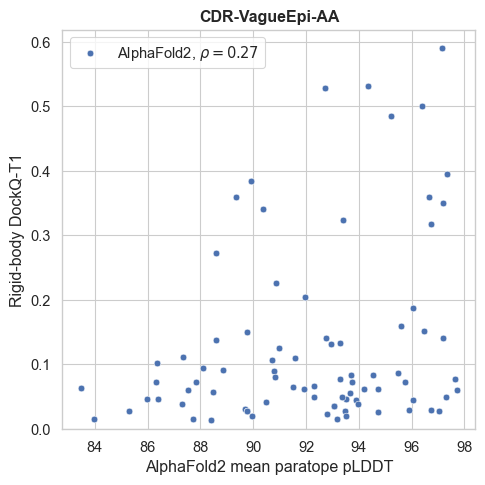

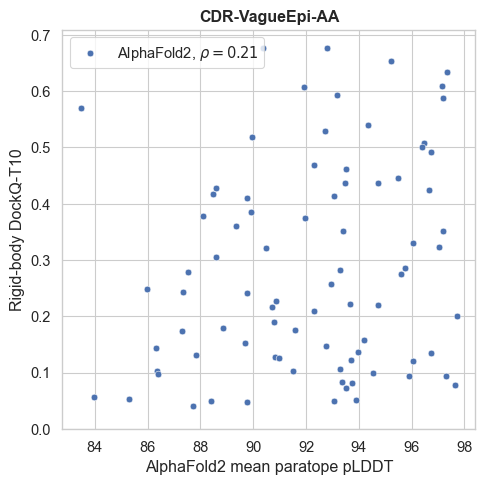

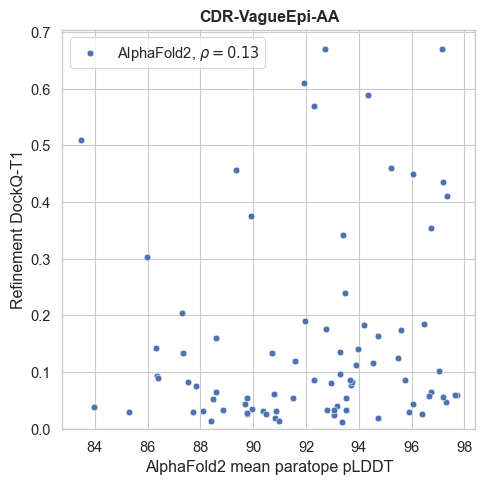

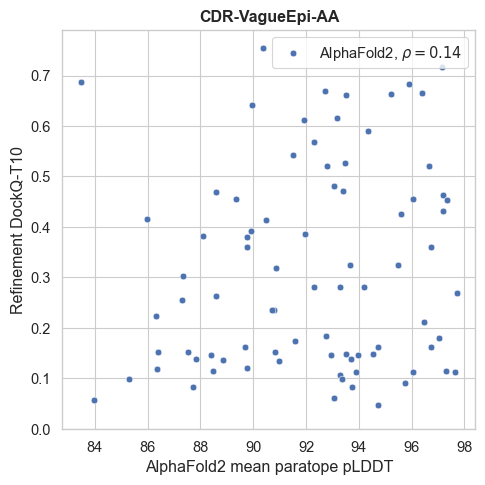

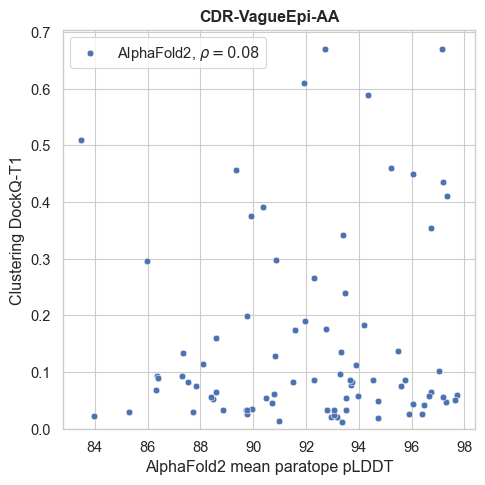

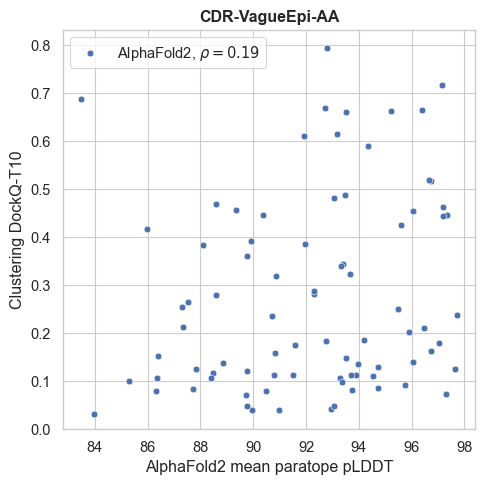

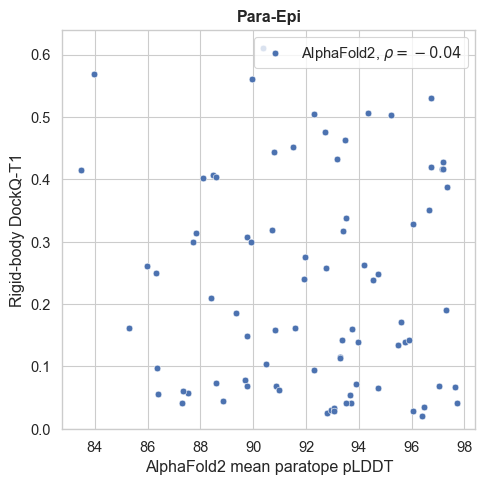

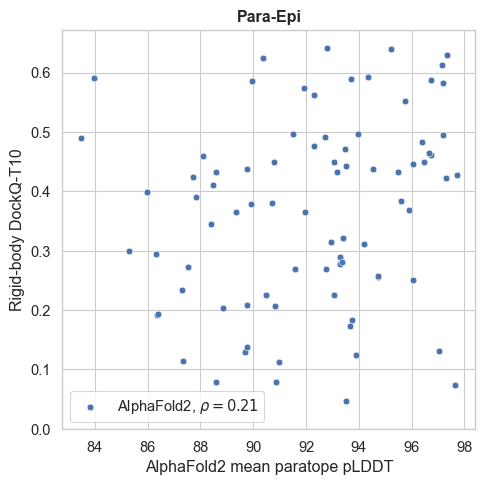

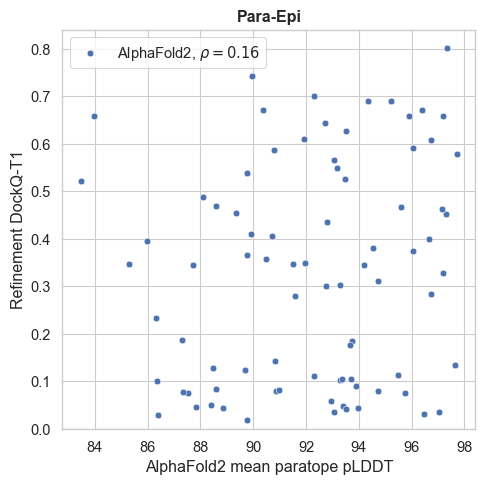

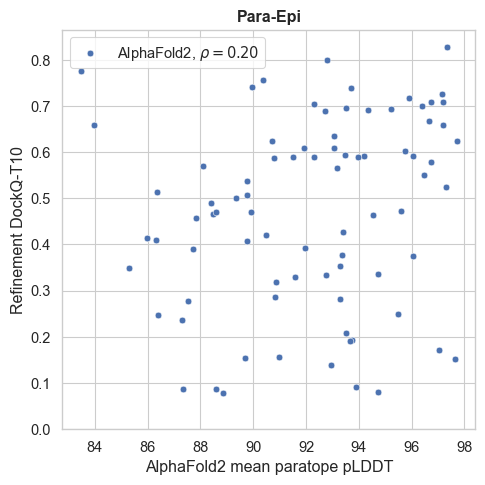

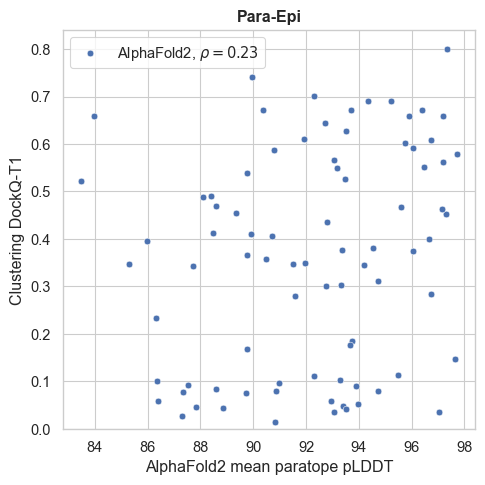

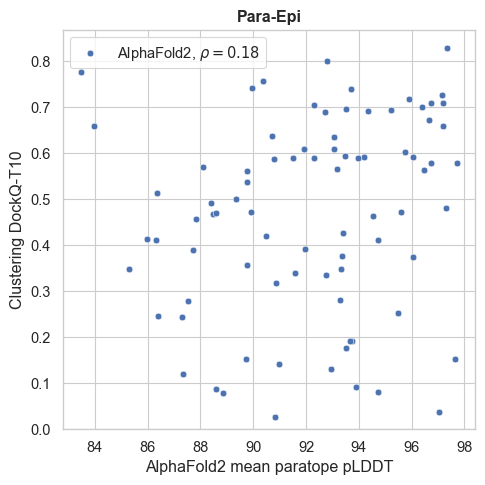

In [42]:
paratope_plddt_df = pd.read_csv('../data/AF2_antibody_rmsd_plddt_multi_regions.csv')
paratope_plddt_dict = {row.pdb : row.plddt_ave_vague for row in paratope_plddt_df.itertuples()}
model_name = 'AlphaFold2'

plot_folder = root_plot_folder / "paratope_vague_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 1')
        top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 10')

        model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

        model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})

        model_df['para_ave_plddt'] = [paratope_plddt_dict[pdbid] for pdbid in model_df['pdb']]


        dockq1_pearson , _ = pearsonr(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['para_ave_plddt'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['para_ave_plddt'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['para_ave_plddt'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['para_ave_plddt'], model_df['dockq_10'])



        sns.scatterplot(x="para_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="para_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean paratope pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_plddt_af2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean paratope pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_plddt_af2_{protocol}_{stage}.png',dpi=200)


# Plot AF2 dockq vs AF2 interface pLDDT

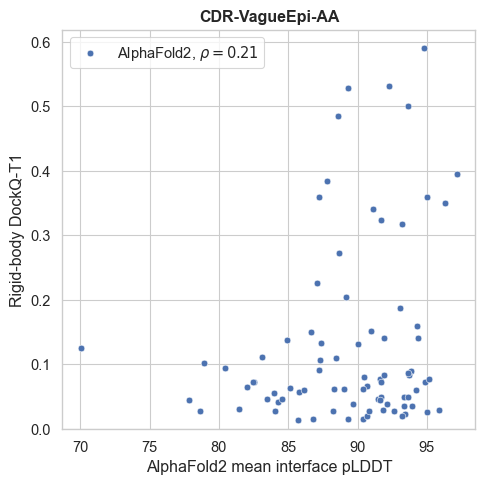

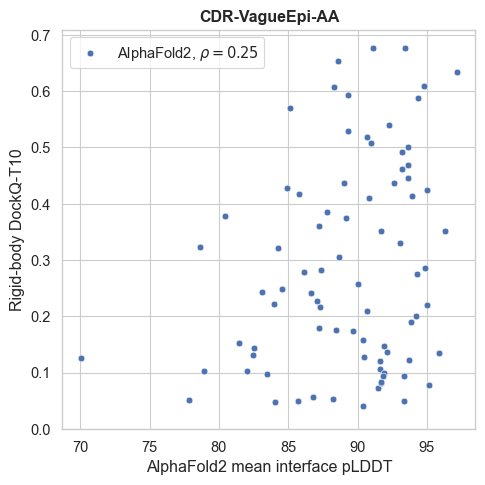

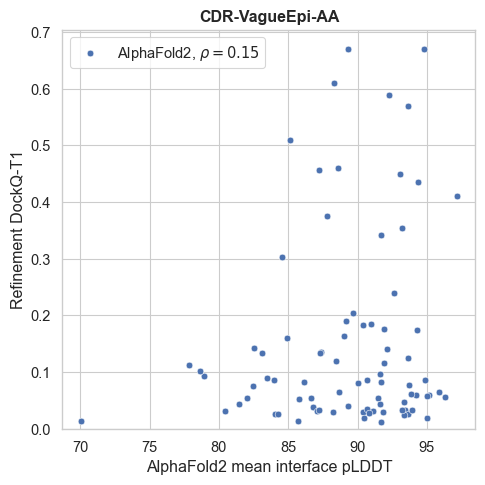

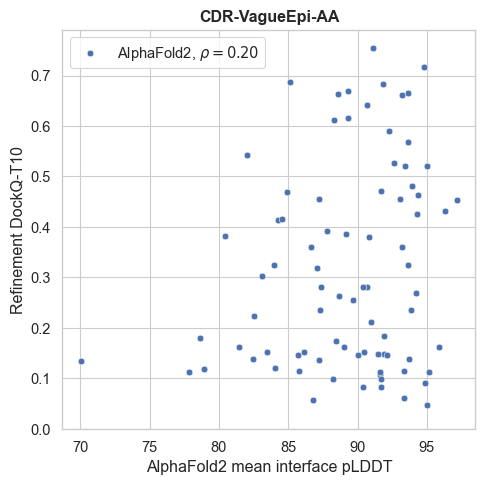

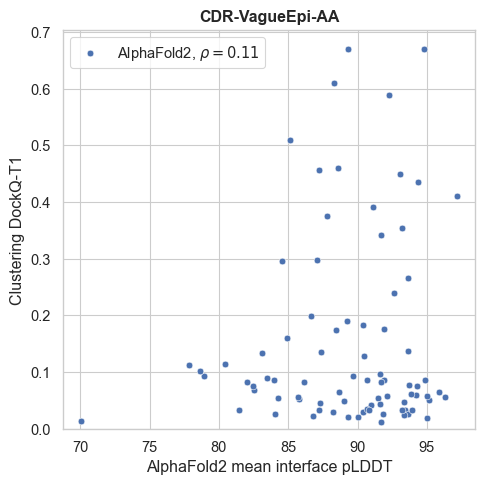

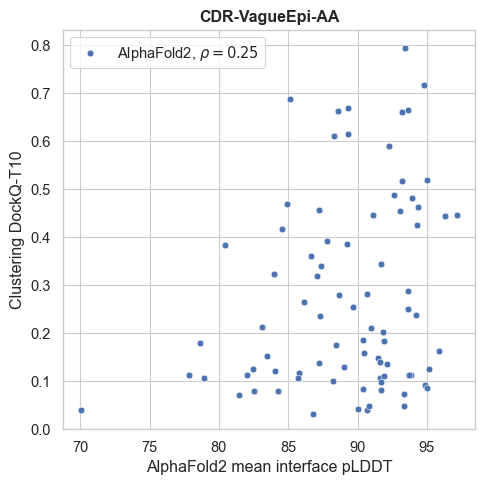

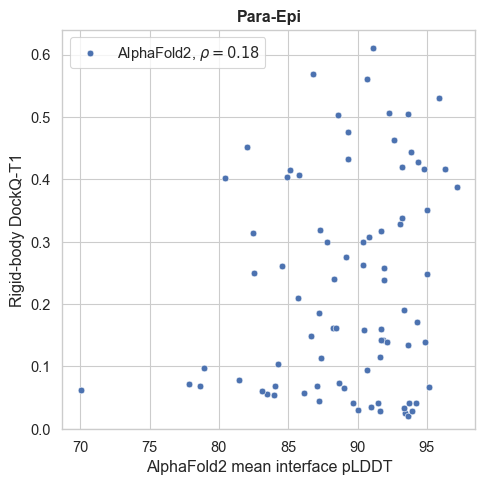

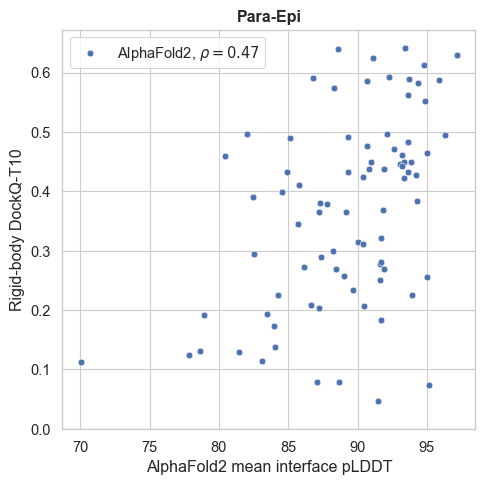

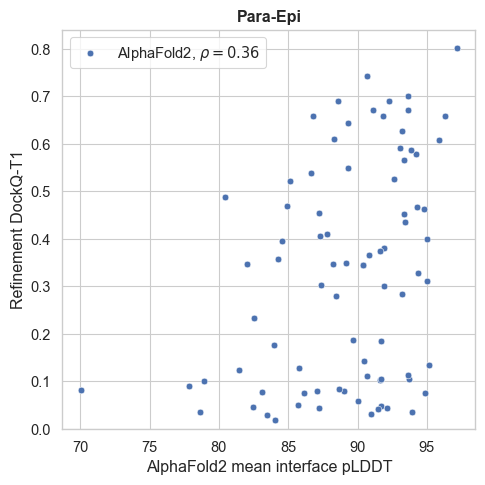

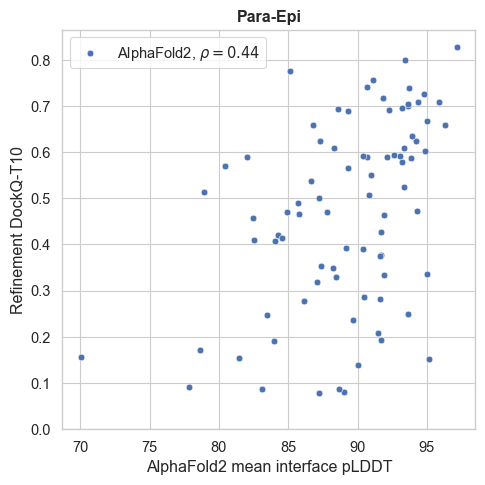

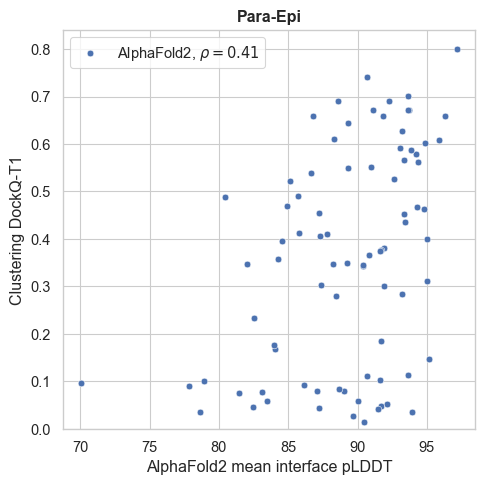

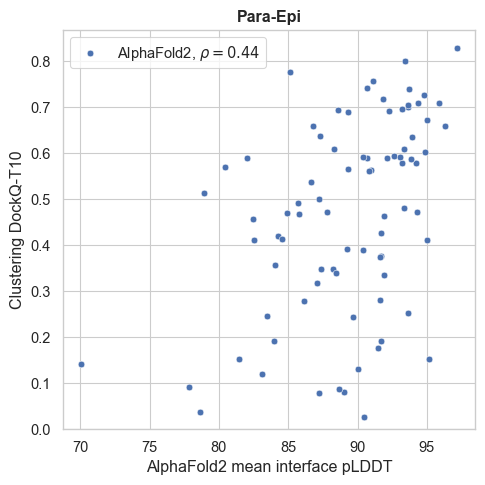

In [43]:
interface_plddt_df = pd.read_csv('../data/AF2_interface_plddt.csv')
interface_plddt_dict = {row.pdb : row.interface_ave_plddt for row in interface_plddt_df.itertuples()}
model_name = 'AlphaFold2'

plot_folder = root_plot_folder / "interface_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)
for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 1')
        top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 10')

        model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

        model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})

        model_df['interface_ave_plddt'] = [interface_plddt_dict[pdbid] for pdbid in model_df['pdb']]

        dockq1_pearson , _ = pearsonr(model_df['interface_ave_plddt'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['interface_ave_plddt'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['interface_ave_plddt'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['interface_ave_plddt'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['interface_ave_plddt'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['interface_ave_plddt'], model_df['dockq_10'])



        sns.scatterplot(x="interface_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="interface_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean interface pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_interface_plddt_af2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean interface pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_interface_plddt_af2_{protocol}_{stage}.png',dpi=200)


# Plot ABB2 dockq vs ABB2 paratope confidence


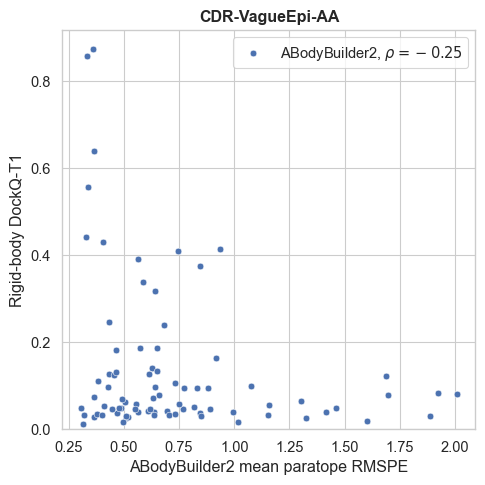

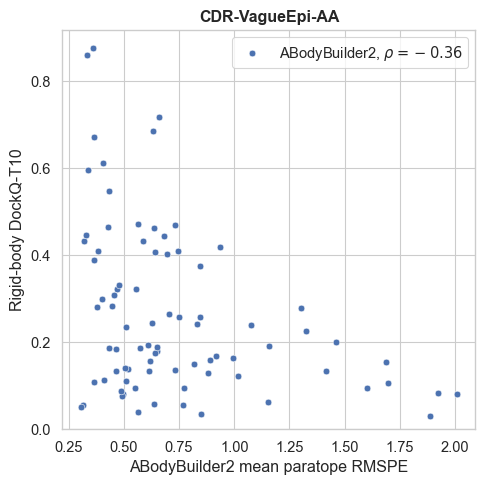

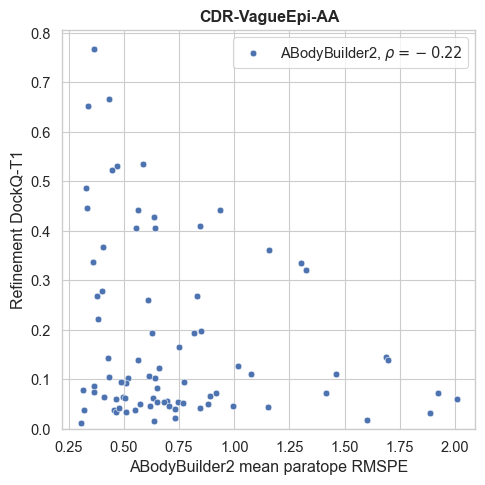

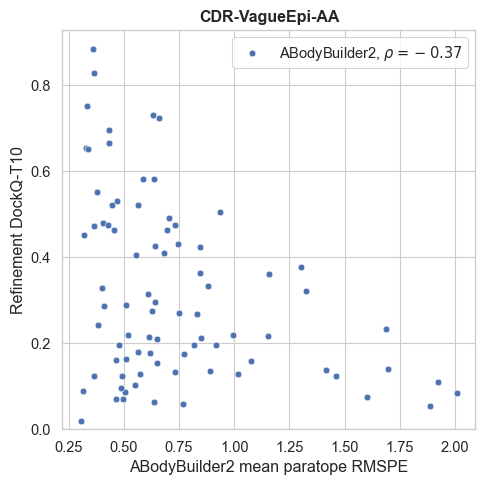

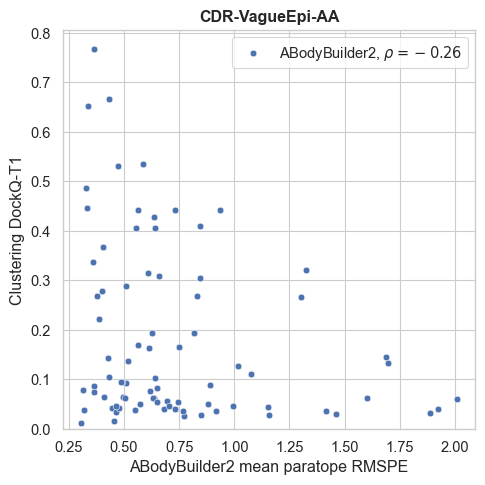

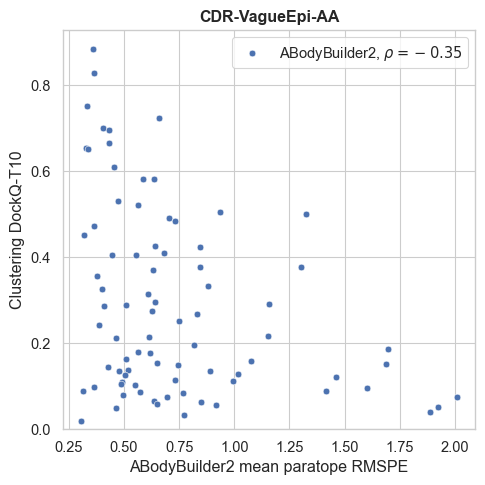

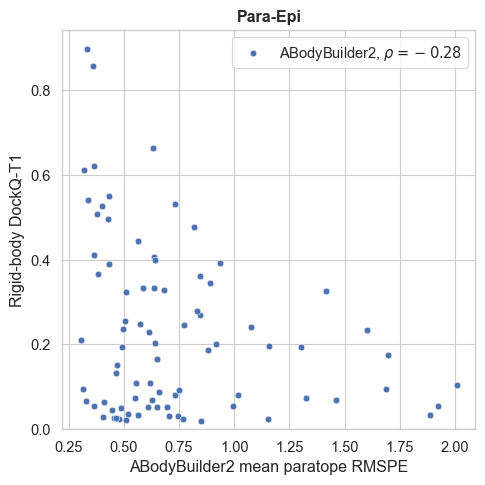

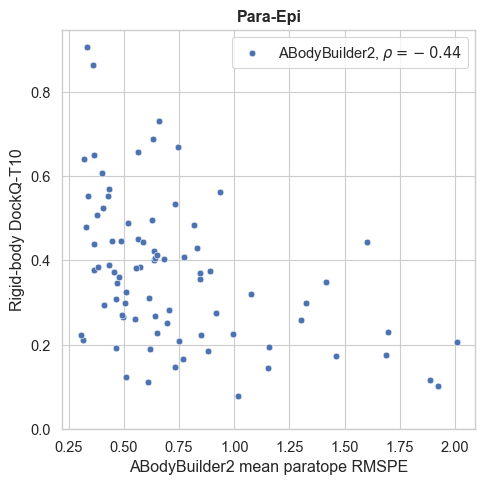

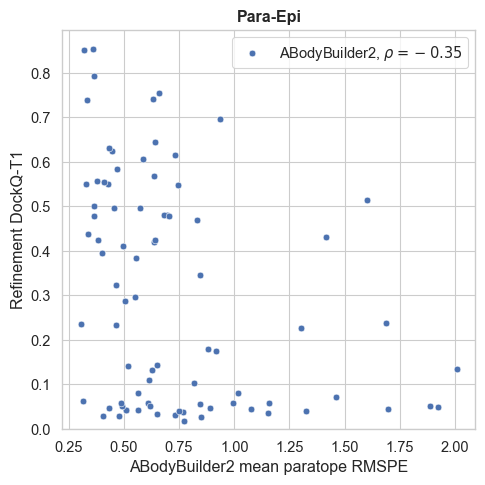

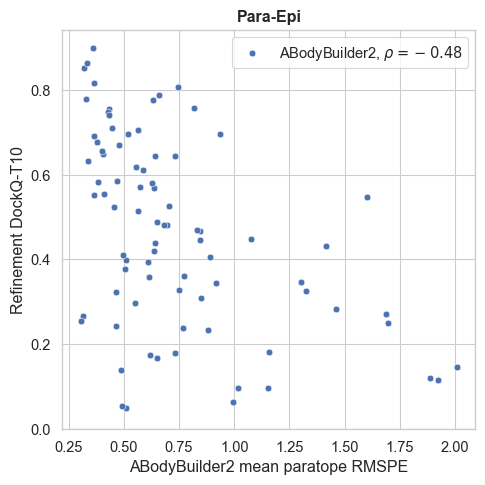

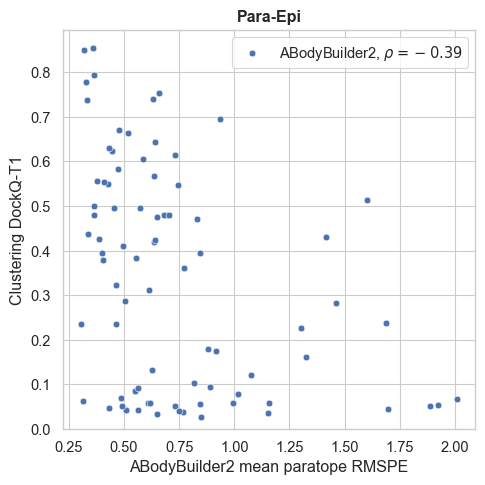

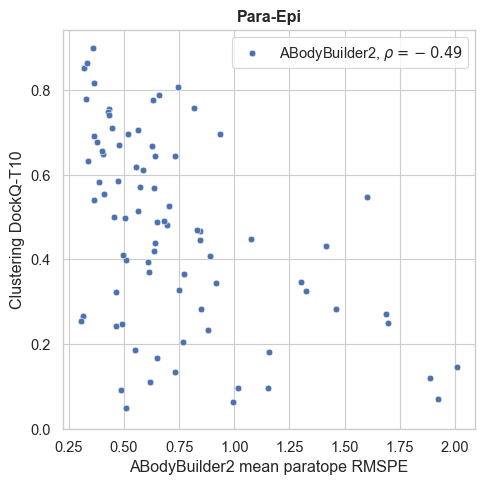

In [44]:
paratope_conf_df = pd.read_csv('../data/ABB2_antibody_rmsd_conf.csv')
paratope_conf_dict = {row.pdb : row.para_ave_conf for row in paratope_conf_df.itertuples()}
model_name= 'ABodyBuilder2'

plot_folder = root_plot_folder / "paratope_conf_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)


for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        model_df['para_ave_conf'] = [paratope_conf_dict[pdbid] for pdbid in model_df['pdb']]
        top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 1')
        top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 10')

        model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

        model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})


        dockq1_pearson , _ = pearsonr(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['para_ave_conf'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['para_ave_conf'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['para_ave_conf'], model_df['dockq_10'])



        sns.scatterplot(x="para_ave_conf", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="para_ave_conf", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'ABodyBuilder2 mean paratope RMSPE')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_conf_ABB2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'ABodyBuilder2 mean paratope RMSPE')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_conf_ABB2_{protocol}_{stage}.png',dpi=200)


# Same but with vague (all cdrs) definition of paratope

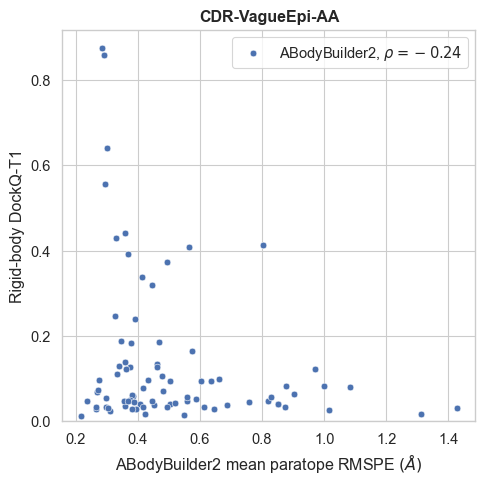

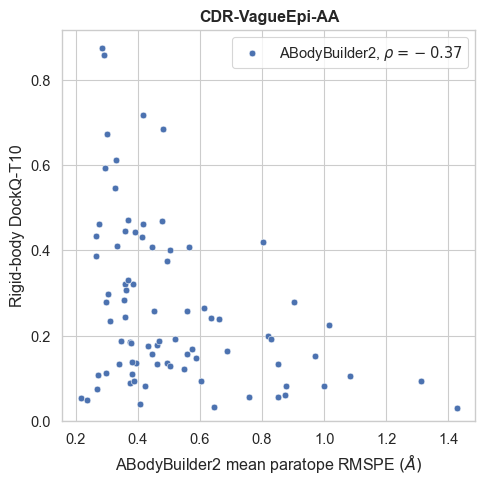

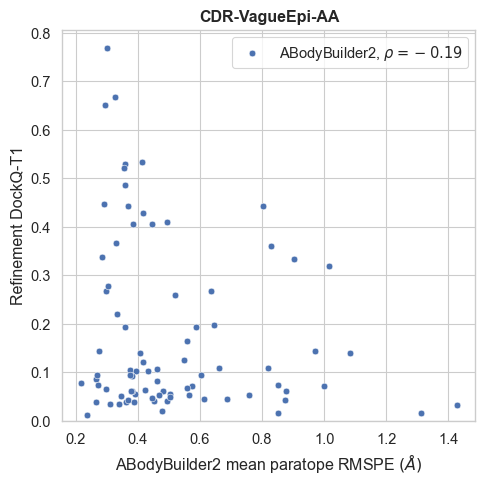

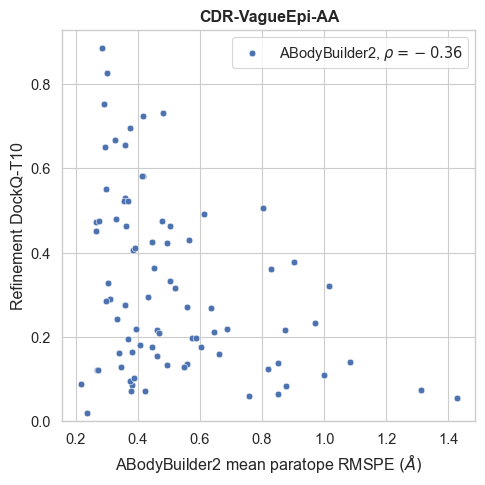

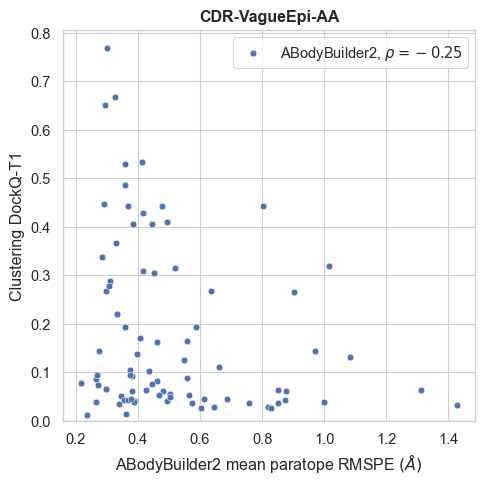

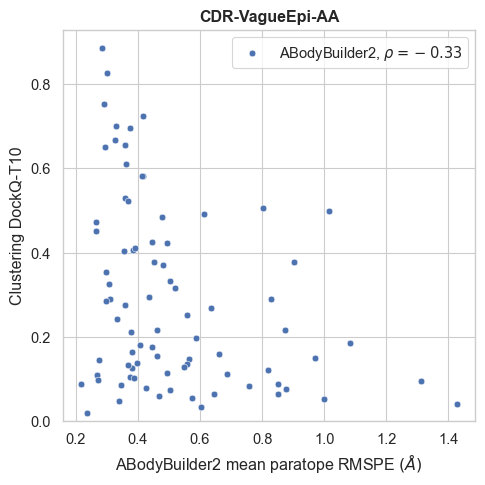

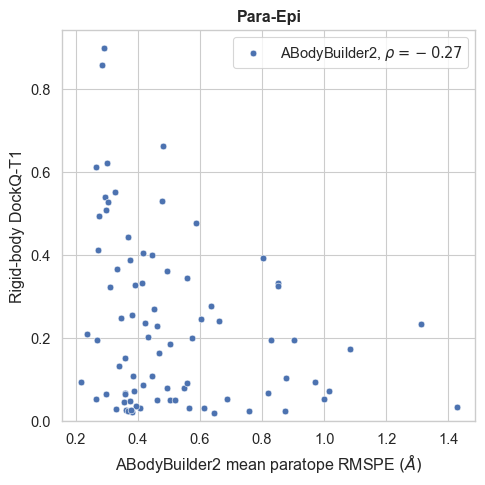

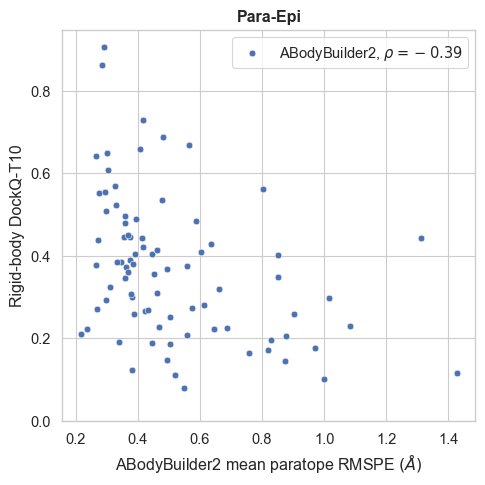

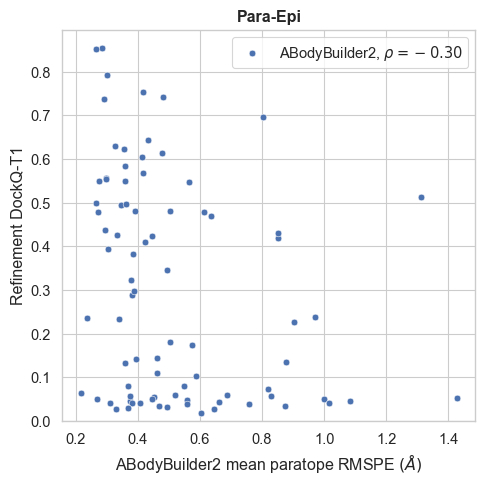

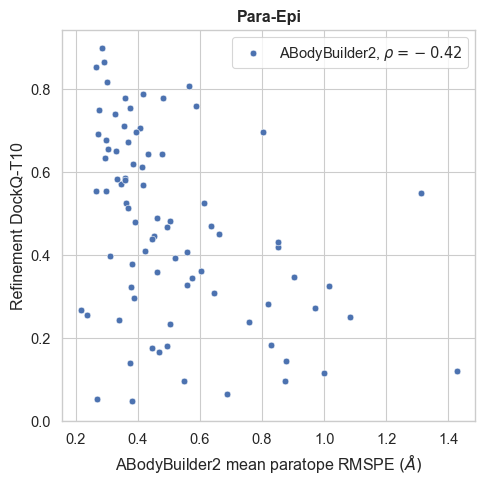

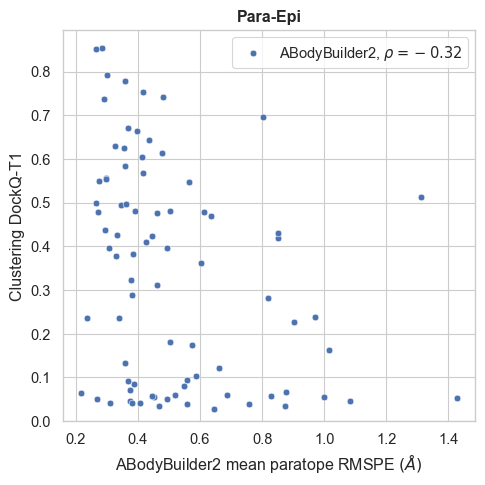

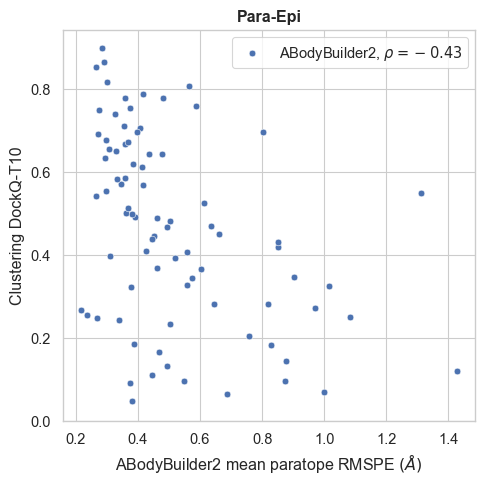

In [45]:
paratope_conf_df = pd.read_csv('../data/ABB2_antibody_rmsd_conf.csv')
paratope_conf_dict = {row.pdb : row.para_vague_ave_conf for row in paratope_conf_df.itertuples()}
model_name, model_run_str = 'ABodyBuilder2', 'ab'

plot_folder = root_plot_folder / "paratope_vague_conf_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)
for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        model_df = rmsds_df.query('model==@model_name').copy()
        model_df['para_ave_conf'] = [paratope_conf_dict[pdbid] for pdbid in model_df['pdb']]
        top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 1')
        top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                          'antigen == @antigen and topn == 10')

        model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

        model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})

        dockq1_pearson , _ = pearsonr(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_pearson , _ = pearsonr(model_df['para_ave_conf'], model_df['dockq_10'])

        dockq1_spearman , _ = spearmanr(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_spearman , _ = spearmanr(model_df['para_ave_conf'], model_df['dockq_10'])

        dockq1_kendall , _ = kendalltau(model_df['para_ave_conf'], model_df['dockq_1'])
        dockq10_kendall , _ = kendalltau(model_df['para_ave_conf'], model_df['dockq_10'])



        sns.scatterplot(x="para_ave_conf", y="dockq_1", data=model_df, ax=ax_dockq1,# marker=markers[i],
                        label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




        sns.scatterplot(x="para_ave_conf", y="dockq_10", data=model_df,ax=ax_dockq10,# marker=markers[i],
                        label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'ABodyBuilder2 mean paratope RMSPE $(\AA)$')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_conf_ABB2_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'ABodyBuilder2 mean paratope RMSPE $(\AA)$')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_conf_ABB2_{protocol}_{stage}.png',dpi=200)


# Plot DockQ vs AF2 antigen pLDDT

In [46]:
epitope_plddt_df = pd.read_csv('../data/AF2_antigen_rmsd_plddt_multi_regions.csv')
epitope_plddt_dict = {row.pdb : row.plddt_ave_para_epi for row in epitope_plddt_df.itertuples()}

plot_folder = root_plot_folder / "epitope_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, model_name in enumerate(model_names):
            model_df = rmsds_df.query('model==@model_name').copy()
            model_df['epi_ave_plddt'] = [epitope_plddt_dict[pdbid] for pdbid in model_df['pdb']]

            top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 1')
            top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 10')

            model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

            model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})


            dockq1_pearson , _ = pearsonr(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['epi_ave_plddt'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['epi_ave_plddt'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['epi_ave_plddt'], model_df['dockq_10'])



            sns.scatterplot(x="epi_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="epi_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean epitope pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_AF2_epitope_plddt_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean epitope pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_AF2_epitope_plddt_all_models_{protocol}_{stage}.png',dpi=200)


# Same but vague epitope definition

In [47]:
epitope_plddt_df = pd.read_csv('../data/AF2_antigen_rmsd_plddt_multi_regions.csv')
epitope_plddt_dict = {row.pdb : row.plddt_ave_vague for row in epitope_plddt_df.itertuples()}

plot_folder = root_plot_folder / "epitope_vague_plddt_AlphaFold2_antigen"
plot_folder.mkdir(exist_ok=True)

for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, model_name in enumerate(model_names):
            model_df = rmsds_df.query('model==@model_name').copy()
            model_df['epi_ave_plddt'] = [epitope_plddt_dict[pdbid] for pdbid in model_df['pdb']]

            top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 1')
            top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 10')

            model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

            model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})


            dockq1_pearson , _ = pearsonr(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['epi_ave_plddt'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['epi_ave_plddt'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['epi_ave_plddt'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['epi_ave_plddt'], model_df['dockq_10'])

            print(model_df['rmsd_paratope'])
            print(model_df['dockq_10'])


            sns.scatterplot(x="epi_ave_plddt", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="epi_ave_plddt", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'AlphaFold2 mean epitope pLDDT')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')

        #ax_dockq1.set_xlim([0,5])
        #ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_AF2_epitope_plddt_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(r'AlphaFold2 mean epitope pLDDT')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        #ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_AF2_epitope_plddt_all_models_{protocol}_{stage}.png',dpi=200)


# Paratope rmsd vs dockq10 with true antigen

In [50]:
plot_folder = root_plot_folder / "paratope_rmsd_true_antigen"
plot_folder.mkdir(exist_ok=True)


for protocol in protocols:
    for stage in stages_to_eval:
        fig_dockq1, ax_dockq1 = plt.subplots(figsize=figsize)
        fig_dockq10, ax_dockq10 = plt.subplots(figsize=figsize)
        markers = ['x','o','+','s']
        for i, (model_name) in enumerate(model_names):
            model_df = rmsds_df.query('model==@model_name').copy()

            top1_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 1')
            top10_subset = topn_dockq_df.query('model_name==@model_name and protocol == @protocol and stage == @stage and '
                                              'antigen == @antigen and topn == 10')

            model_df = model_df.merge(top1_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_1'})

            model_df= model_df.merge(top10_subset[['pdb','topn_dockq']], on='pdb',how='left').rename(columns={'topn_dockq':'dockq_10'})
            dockq1_pearson , _ = pearsonr(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_pearson , _ = pearsonr(model_df['rmsd_paratope'], model_df['dockq_10'])

            dockq1_spearman , _ = spearmanr(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_spearman , _ = spearmanr(model_df['rmsd_paratope'], model_df['dockq_10'])

            dockq1_kendall , _ = kendalltau(model_df['rmsd_paratope'], model_df['dockq_1'])
            dockq10_kendall , _ = kendalltau(model_df['rmsd_paratope'], model_df['dockq_10'])



            sns.scatterplot(x="rmsd_paratope", y="dockq_1", data=model_df, ax=ax_dockq1, marker=markers[i],
                            label=rf'{model_name}, $\rho= {dockq1_pearson:.2f}$')




            sns.scatterplot(x="rmsd_paratope", y="dockq_10", data=model_df,ax=ax_dockq10, marker=markers[i],
                            label=rf'{model_name}, $\rho = {dockq10_pearson:.2f}$')
            plt.close()
        ax_dockq1.set_title(f'{protocol}', fontweight='bold')
        ax_dockq1.set_xlabel(r'Paratope RMSD $\left(\AA\right)$')
        ax_dockq1.set_ylabel(fr'{stage} DockQ-T1')
        #ax_dockq1.set_xlim([0,5])
        ax_dockq1.set_xlim(left=0)
        ax_dockq1.set_ylim(bottom=0)
        ax_dockq1.legend()
        fig_dockq1.tight_layout()
        fig_dockq1.savefig(plot_folder/f'dockq1_paratope_rmsd_true_anti_all_models_{protocol}_{stage}.png',dpi=200)

        ax_dockq10.set_title(f'{protocol}', fontweight='bold')
        ax_dockq10.set_xlabel(fr'Paratope RMSD $\left(\AA\right)$')
        ax_dockq10.set_ylabel(fr'{stage} DockQ-T10')
        #ax_dockq10.set_xlim([0,5])
        ax_dockq10.set_xlim(left=0)
        ax_dockq10.set_ylim(bottom=0)
        ax_dockq10.legend()
        fig_dockq10.tight_layout()
        fig_dockq10.savefig(plot_folder/f'dockq10_paratope_rmsd_true_anti_all_models_{protocol}_{stage}.png',dpi=200)


0     3.427635
1     0.822135
2     1.740288
3     1.697944
4     2.108230
        ...   
77    1.473584
78    1.150733
79    3.188704
80    4.215847
81    1.971337
Name: rmsd_paratope, Length: 82, dtype: float64
0     0.278
1     0.875
2     0.401
3     0.054
4     0.061
      ...  
77    0.685
78    0.672
79    0.128
80    0.191
81    0.188
Name: dockq_10, Length: 82, dtype: float64
-0.448870197251098
0     3.929652
1     1.525369
2     1.089273
3     1.354067
4     1.398893
        ...   
77    1.032697
78    1.687134
79    2.507088
80    3.343383
81    2.011022
Name: rmsd_paratope, Length: 82, dtype: float64
0     0.102
1     0.677
2     0.417
3     0.107
4     0.051
      ...  
77    0.469
78    0.413
79    0.385
80    0.249
81    0.180
Name: dockq_10, Length: 82, dtype: float64
-0.3861338597422144
0     3.984237
1     2.086035
2     1.810361
3     1.762266
4     2.945631
        ...   
77    2.083849
78    2.086994
79    2.770474
80    4.505235
81    1.595221
Name: rmsd_paratope,